# Clustering de películas (TMDB)
Preparación de datos para clustering con preprocesamiento completo: selección de variables, nulos, outliers, escalado y correlación.

In [2]:
# 1) Cargar datos
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

df = pd.read_csv('data/movies_2026.csv',encoding='latin-1')
print(df.shape)
df.head(3)

(19883, 28)


,id,budget,genres,homePage,productionCompany,productionCompanyCountry,productionCountry,revenue,runtime,video,...,releaseDate,voteAvg,voteCount,genresAmount,productionCoAmount,productionCountriesAmount,actorsAmount,castWomenAmount,castMenAmount,releaseYear
0,1627085,0.0,Drama|Crime,NaN,NaN,NaN,NaN,0.0,95,False,...,2026-02-01,0.0,0,2,0,0,8,2.0,5.0,2026.0
1,1626914,0.0,Animation,NaN,NaN,NaN,NaN,0.0,3,False,...,2026-02-01,0.0,0,1,0,0,4,0.0,0.0,2026.0
2,1626898,0.0,Animation,NaN,NaN,NaN,NaN,0.0,2,False,...,2026-02-01,0.0,0,1,0,0,3,0.0,0.0,2026.0


## Selección e ingeniería de variables para clustering
En esta etapa se construye la matriz de features (`X`) combinando variables numéricas base con señales derivadas de columnas tipo array (`|`).

**Variables numéricas base**: `popularity`, `budget`, `revenue`, `runtime`, `voteAvg`, `voteCount`, `castWomenAmount`, `castMenAmount`, `releaseYear`.

**Ingeniería sobre arrays de actores** (`actorsPopularity`):
- `actorsPopularityMean`
- `actorsPopularityMax`
- `actorsPopularityStd`
- `actorsHighPopularityShare` (proporción de actores por encima del percentil 75 global)

**Codificación multi-hot de contenido** (categorías más frecuentes):
- Géneros: `genre_*` (top 12)
- País de producción: `prodCountry_*` (top 10)
- Productora: `prodCompany_*` (top 15)

Finalmente, se arma `X = df[features]`, se revisan nulos por variable y se reporta el total de features usadas para el clustering.

In [3]:
# 3) Construir matriz base de features (priorizando valor semántico en arrays, no solo conteos)
def split_pipe_tokens(value):
    if pd.isna(value) or str(value).strip() == '':
        return []
    return [t.strip() for t in str(value).split('|') if str(t).strip() != '']

def parse_pipe_numeric(value):
    vals = []
    for token in split_pipe_tokens(value):
        try:
            vals.append(float(token))
        except ValueError:
            pass
    return vals

def split_mean_numeric(series):
    return series.apply(lambda v: float(np.mean(parse_pipe_numeric(v))) if len(parse_pipe_numeric(v)) > 0 else np.nan)

def split_max_numeric(series):
    return series.apply(lambda v: float(np.max(parse_pipe_numeric(v))) if len(parse_pipe_numeric(v)) > 0 else np.nan)

def split_std_numeric(series):
    return series.apply(lambda v: float(np.std(parse_pipe_numeric(v))) if len(parse_pipe_numeric(v)) > 1 else 0.0)

# Detectar columnas tipo array (texto con '|')
array_text_cols = []
for col in df.columns:
    if df[col].dtype == 'object':
        pipe_ratio = df[col].astype(str).str.contains(r'\|', regex=True, na=False).mean()
        if pipe_ratio > 0.05:
            array_text_cols.append(col)

print('Columnas detectadas como array:', array_text_cols)

# Señales de relevancia desde actorsPopularity (no solo promedio)
df['actorsPopularityMean'] = split_mean_numeric(df['actorsPopularity'])
df['actorsPopularityMax'] = split_max_numeric(df['actorsPopularity'])
df['actorsPopularityStd'] = split_std_numeric(df['actorsPopularity'])

# Proporción de actores "muy populares" por película (top 25% global de popularidad de actores)
all_actor_pops = []
for value in df['actorsPopularity']:
    all_actor_pops.extend(parse_pipe_numeric(value))
high_pop_threshold = np.percentile(all_actor_pops, 75) if len(all_actor_pops) > 0 else np.nan

def high_pop_share(value, threshold):
    vals = parse_pipe_numeric(value)
    if len(vals) == 0 or pd.isna(threshold):
        return np.nan
    return float(np.mean(np.array(vals) >= threshold))

df['actorsHighPopularityShare'] = df['actorsPopularity'].apply(lambda v: high_pop_share(v, high_pop_threshold))

# Función para crear dummies de top categorías en columnas tipo array
def build_top_multihot(df_in, source_col, prefix, top_n):
    long_tokens = (
        df_in[source_col]
        .apply(split_pipe_tokens)
        .explode()
        .dropna()
    )
    long_tokens = long_tokens[long_tokens != '']
    top_values = long_tokens.value_counts().head(top_n).index.tolist()

    created_cols = []
    for token in top_values:
        safe_token = str(token).replace(' ', '_').replace('/', '_').replace('-', '_')
        col_name = f'{prefix}_{safe_token}'
        df_in[col_name] = df_in[source_col].apply(
            lambda v: int(token in split_pipe_tokens(v))
        )
        created_cols.append(col_name)

    return created_cols

# Arrays que realmente aportan valor semántico
genre_feature_cols = build_top_multihot(df, 'genres', 'genre', top_n=12)
prod_country_feature_cols = build_top_multihot(df, 'productionCountry', 'prodCountry', top_n=10)
prod_company_feature_cols = build_top_multihot(df, 'productionCompany', 'prodCompany', top_n=15)

features = [
    'popularity', 'budget', 'revenue', 'runtime', 'voteAvg', 'voteCount',
    'actorsPopularityMean', 'actorsPopularityMax', 'actorsPopularityStd',
    'actorsHighPopularityShare', 'castWomenAmount', 'castMenAmount', 'releaseYear'
 ] + genre_feature_cols + prod_country_feature_cols + prod_company_feature_cols

X = df[features].copy()

missing = X.isna().sum().sort_values(ascending=False)
print('Nulos por variable:')
display(missing[missing > 0])
print(f'Features totales para clustering: {X.shape[1]}')
print('Ejemplo columnas de género:', genre_feature_cols[:5])
print('Ejemplo columnas de país producción:', prod_country_feature_cols[:5])
print('Ejemplo columnas de productora:', prod_company_feature_cols[:5])

Columnas detectadas como array: ['genres', 'productionCompany', 'productionCompanyCountry', 'productionCountry', 'director', 'actors', 'actorsPopularity', 'actorsCharacter']
Nulos por variable:


actorsHighPopularityShare    2644
actorsPopularityMax          2644
actorsPopularityMean         2644
castMenAmount                 162
castWomenAmount                37
releaseYear                     2
dtype: int64

Features totales para clustering: 50
Ejemplo columnas de género: ['genre_Drama', 'genre_Comedy', 'genre_Thriller', 'genre_Action', 'genre_Documentary']
Ejemplo columnas de país producción: ['prodCountry_United_States_of_America', 'prodCountry_United_Kingdom', 'prodCountry_US', 'prodCountry_Japan', 'prodCountry_France']
Ejemplo columnas de productora: ['prodCompany_Warner_Bros._Pictures', 'prodCompany_Universal_Pictures', 'prodCompany_Columbia_Pictures', 'prodCompany_Paramount', 'prodCompany_20th_Century_Fox']


In [4]:
# 4) Manejo de nulos (imputación robusta con mediana)
X = X.apply(pd.to_numeric, errors='coerce')
X_imputed = X.fillna(X.median(numeric_only=True))
print('Nulos restantes:', int(X_imputed.isna().sum().sum()))

Nulos restantes: 0


In [5]:
# 5) Manejo de outliers (winsorización por IQR solo en variables continuas)
# Nota: NO aplicar clipping IQR a dummies/binarias (0/1), porque puede colapsarlas a 0
X_clean = X_imputed.copy()

binary_cols = [
    c for c in X_imputed.columns
    if set(X_imputed[c].dropna().unique()).issubset({0, 1})
]

continuous_cols = [c for c in X_imputed.columns if c not in binary_cols]

if continuous_cols:
    Q1 = X_imputed[continuous_cols].quantile(0.25)
    Q3 = X_imputed[continuous_cols].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    X_clean[continuous_cols] = X_imputed[continuous_cols].clip(lower=lower, upper=upper, axis=1)

print('Shape tras control de outliers:', X_clean.shape)
print(f'Columnas binarias preservadas (sin clipping): {len(binary_cols)}')
print(f'Columnas continuas con clipping IQR: {len(continuous_cols)}')

Shape tras control de outliers: (19883, 50)
Columnas binarias preservadas (sin clipping): 37
Columnas continuas con clipping IQR: 13


In [6]:
# 6) Escalado (removiendo variables sin variación)
nunique = X_clean.nunique(dropna=False)
constant_cols = nunique[nunique <= 1].index.tolist()
X_model = X_clean.drop(columns=constant_cols) if constant_cols else X_clean.copy()

if constant_cols:
    print('Columnas removidas por varianza cero:', constant_cols)
else:
    print('No hay columnas con varianza cero')

scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X_model), columns=X_model.columns, index=X_model.index)
X_scaled.describe().T[['mean', 'std']].head()

No hay columnas con varianza cero


,mean,std
popularity,-1.829693e-16,1.000025
budget,4.574233e-17,1.000025
revenue,0.000000e+00,1.000025
runtime,9.148466e-17,1.000025
voteAvg,-1.829693e-16,1.000025


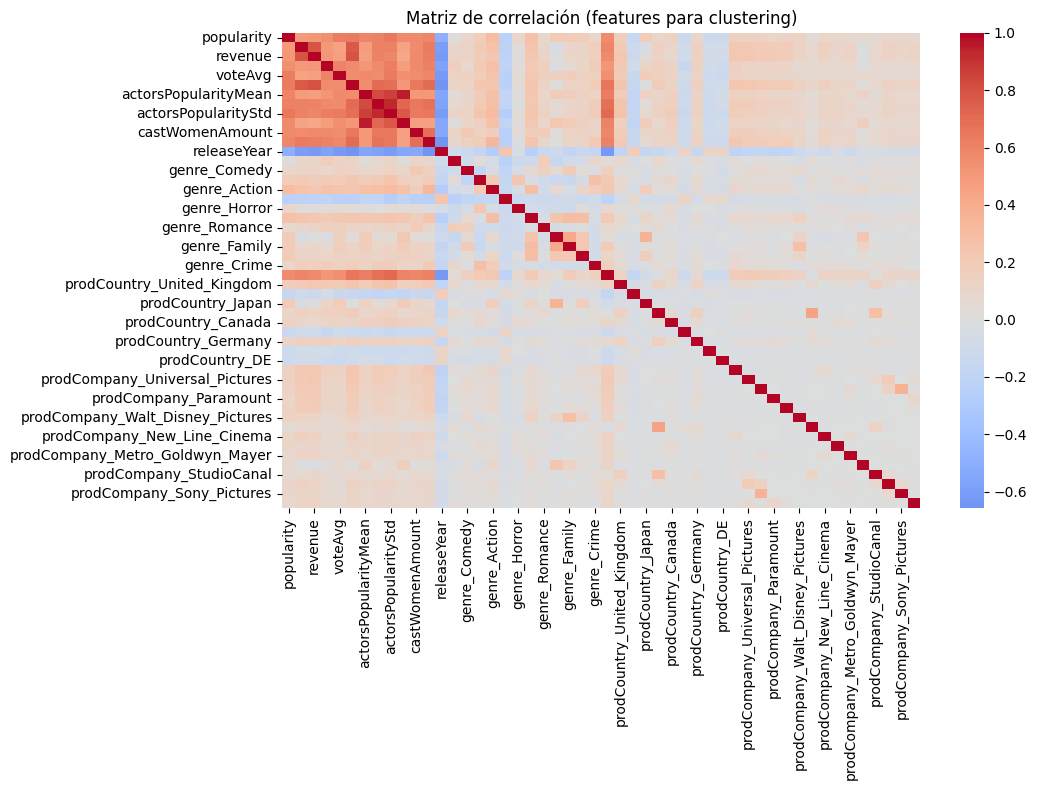

In [7]:
# 7) Matriz de correlación
corr = X_scaled.corr()
plt.figure(figsize=(11, 8))
sns.heatmap(corr, cmap='coolwarm', center=0, annot=False)
plt.title('Matriz de correlación (features para clustering)')
plt.tight_layout()
plt.show()

##  Tendencia al clustering: estadístico de Hopkins
Resultado obtenido: **H = 0.9387**.

Interpretación:
- `H` cercano a 0.5: datos casi aleatorios.
- `H` > 0.70: tendencia clara a clustering.
- Con `H = 0.9387`, el dataset presenta **muy fuerte tendencia a formar clusters**.

In [8]:
# 9) Cálculo de Hopkins
from sklearn.neighbors import NearestNeighbors

rng = np.random.default_rng(42)
X_h = X_scaled.to_numpy()
n = X_h.shape[0]
d = X_h.shape[1]

m = min(1000, max(100, int(0.05 * n)))  # tamaño de muestra
idx = rng.choice(n, size=m, replace=False)
X_sample = X_h[idx]

mins = X_h.min(axis=0)
maxs = X_h.max(axis=0)
U = rng.uniform(mins, maxs, size=(m, d))

nn_data = NearestNeighbors(n_neighbors=2).fit(X_h)
w_dist, _ = nn_data.kneighbors(X_sample, n_neighbors=2)
W = w_dist[:, 1].sum()

u_dist, _ = nn_data.kneighbors(U, n_neighbors=1)
U_sum = u_dist[:, 0].sum()

hopkins = float(U_sum / (U_sum + W))
print(f'Hopkins H = {hopkins:.4f} (m={m})')

Hopkins H = 0.9387 (m=994)


## VAT (Visual Assessment of Tendency)
Sí fue posible ejecutar VAT sobre una muestra de **n=1200**.

Comentario: se usó muestra porque VAT requiere una matriz de distancias de tamaño \(n^2\); en el dataset completo sería más costoso en memoria/tiempo.

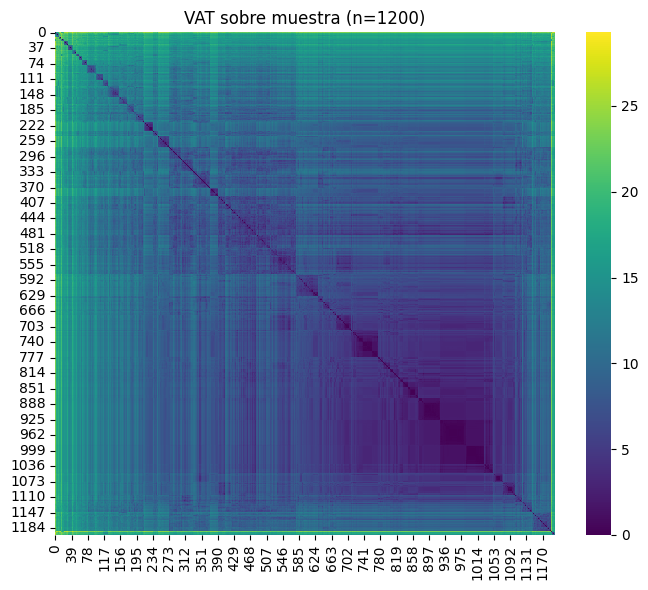

VAT fue posible con muestra n=1200.


In [9]:
# 11) VAT sobre muestra
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import linkage, leaves_list

vat_possible = True
vat_reason = ''
n_vat = min(1200, len(X_scaled))

try:
    X_vat = X_scaled.sample(n=n_vat, random_state=42).to_numpy()
    d_condensed = pdist(X_vat, metric='euclidean')
    Z = linkage(d_condensed, method='average')
    order = leaves_list(Z)
    D = squareform(d_condensed)
    D_ordered = D[np.ix_(order, order)]

    plt.figure(figsize=(7, 6))
    sns.heatmap(D_ordered, cmap='viridis', cbar=True)
    plt.title(f'VAT sobre muestra (n={n_vat})')
    plt.tight_layout()
    plt.show()

    print(f'VAT fue posible con muestra n={n_vat}.')
except Exception as e:
    vat_possible = False
    vat_reason = str(e)
    print('VAT no fue posible en esta ejecución.')
    print('Motivo:', vat_reason)

## k elegido 
Se elige **k = 2**.

Justificación breve:
- La **silueta máxima** se obtiene en `k=2` (**0.2307**).
- La curva de **codo** muestra caída fuerte inicial y luego ganancias decrecientes.
- Por ambos criterios, `k=2` es la opción más consistente para este preprocesamiento.

k óptimo por silueta: 2 (score=0.2307, n_eval=6000)


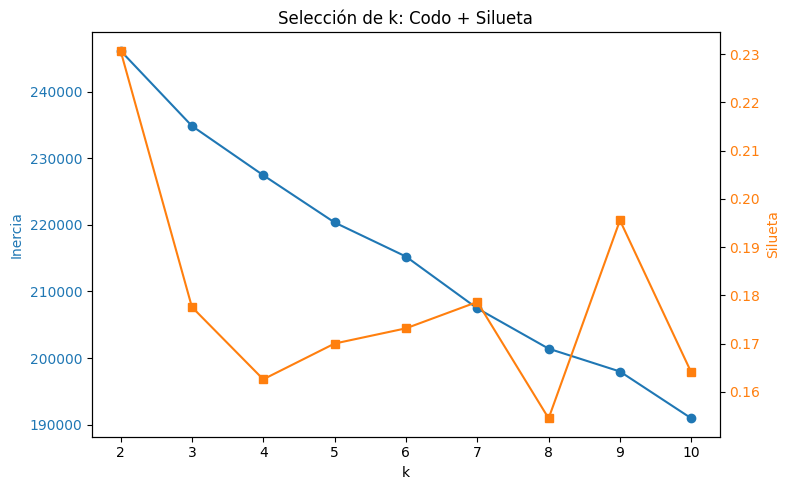

In [10]:

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

k_values = list(range(2, 11))
inertias = []
sil_scores = []

n_eval = min(6000, len(X_scaled))
X_eval = X_scaled.sample(n=n_eval, random_state=42) if len(X_scaled) > n_eval else X_scaled

for k in k_values:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = km.fit_predict(X_eval)
    inertias.append(km.inertia_)
    sil_scores.append(silhouette_score(X_eval, labels))

k_opt = k_values[int(np.argmax(sil_scores))]
print(f'k óptimo por silueta: {k_opt} (score={max(sil_scores):.4f}, n_eval={len(X_eval)})')

fig, ax1 = plt.subplots(figsize=(8, 5))
ax1.plot(k_values, inertias, marker='o', color='tab:blue')
ax1.set_xlabel('k')
ax1.set_ylabel('Inercia', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

ax2 = ax1.twinx()
ax2.plot(k_values, sil_scores, marker='s', color='tab:orange')
ax2.set_ylabel('Silueta', color='tab:orange')
ax2.tick_params(axis='y', labelcolor='tab:orange')

plt.title('Selección de k: Codo + Silueta')
fig.tight_layout()
plt.show()

##  Aplicar KMeans y Clustering Jerárquico (k=2)
Se aplican ambos métodos con el `k` elegido y se comparan visualmente y con métricas internas.

In [11]:
#  Entrenar ambos modelos y visualizar en 2D (PCA)
from sklearn.cluster import AgglomerativeClustering
from sklearn.decomposition import PCA

k_final = int(k_opt) if 'k_opt' in globals() else 2

kmeans_model = KMeans(n_clusters=k_final, random_state=42, n_init=20)
labels_kmeans = kmeans_model.fit_predict(X_scaled)

hier_model = AgglomerativeClustering(n_clusters=k_final, linkage='ward')
labels_hier = hier_model.fit_predict(X_scaled)


In [12]:
#  Comparación cuantitativa: Silueta + Davies-Bouldin
from sklearn.metrics import silhouette_score, davies_bouldin_score

metrics_df = pd.DataFrame({
    'modelo': ['KMeans', 'Jerárquico (Ward)'],
    'silhouette': [
        silhouette_score(X_scaled, labels_kmeans),
        silhouette_score(X_scaled, labels_hier)
    ],
    'davies_bouldin': [
        davies_bouldin_score(X_scaled, labels_kmeans),
        davies_bouldin_score(X_scaled, labels_hier)
    ]
})

display(metrics_df)

best_by_sil = metrics_df.loc[metrics_df['silhouette'].idxmax(), 'modelo']
best_by_db = metrics_df.loc[metrics_df['davies_bouldin'].idxmin(), 'modelo']
recommended_model = best_by_sil if best_by_sil == best_by_db else best_by_sil

print(f'Mejor por silueta: {best_by_sil}')
print(f'Mejor por Davies-Bouldin (menor es mejor): {best_by_db}')
print(f'Modelo recomendado: {recommended_model}')

,modelo,silhouette,davies_bouldin
0,KMeans,0.226478,1.998437
1,Jerárquico (Ward),0.204966,2.008739


Mejor por silueta: KMeans
Mejor por Davies-Bouldin (menor es mejor): KMeans
Modelo recomendado: KMeans


##  Conclusión del método a usar
Uso de **KMeans** con `k=2`.

Razón:
- Tiene mayor **silueta** (`0.2265` vs `0.2050`), indicando mejor separación/cohesión relativa.
- Tiene menor **Davies-Bouldin** (`1.9984` vs `2.0087`), indicando mejor compactación/separación relativa.
- También es más simple y eficiente para este tamaño de dataset.

##  Interpretación de clusters (KMeans)
Se perfilan los grupos con estadísticas descriptivas y un heatmap de medias estandarizadas por cluster.

Tamaño por cluster:


,n_peliculas,pct
cluster,,
0,10877,54.71
1,9006,45.29


Estadísticas por cluster (media y mediana):


popularity                budget                  revenue             \
              mean  median          mean     median          mean     median   
cluster                                                                        
0            4.275   0.064  5.958693e+04        0.0  1.021457e+05        0.0   
1           52.788  22.182  2.071021e+07  3000000.0  6.344248e+07  2699632.5   

         runtime        voteAvg         ...  \
            mean median    mean median  ...   
cluster                                 ...   
0         35.772   13.0   1.620    0.0  ...   
1        102.715  101.0   6.514    6.6  ...   

        prodCompany_Warner_Bros._Animation        prodCompany_StudioCanal  \
                                      mean median                    mean   
cluster                                                                     
0                                    0.000    0.0                   0.001   
1                                    0.014    0.0                   0.013   

               prodCompany_Relativity_Media        prodCompany_Sony_Pictures  \
        median                         mean median                      mean   
cluster                                                                        
0          0.0                        0.000    0.0                     0.000   
1          0.0                        0.013    0.0                     0.013   

               prodCompany_DreamWorks_Pictures         
        median                            mean median  
cluster                                                
0          0.0                           0.000    0.0  
1          0.0                           0.012    0.0  

[2 rows x 100 columns]

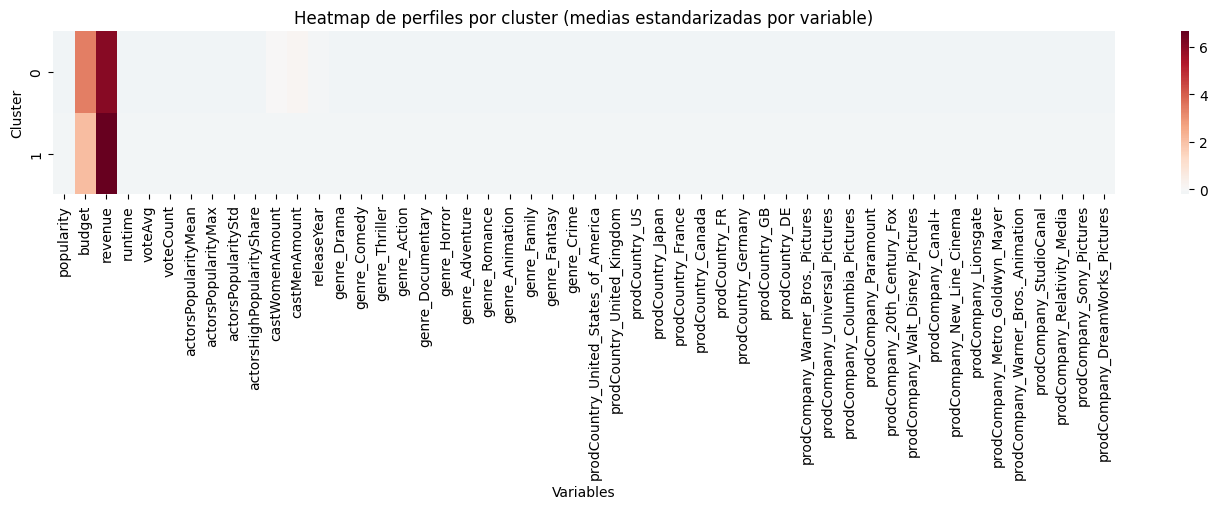

In [13]:
from sklearn.preprocessing import StandardScaler

# Asegurar etiquetas del mejor modelo (KMeans)
if 'labels_kmeans' not in globals():
    kmeans_model = KMeans(n_clusters=2, random_state=42, n_init=20)
    labels_kmeans = kmeans_model.fit_predict(X_scaled)

df_cluster = df.copy()
df_cluster['cluster'] = labels_kmeans

base_profile_cols = [
    'popularity', 'budget', 'revenue', 'runtime', 'voteAvg', 'voteCount',
    'actorsPopularityMean', 'actorsPopularityMax', 'actorsPopularityStd', 'actorsHighPopularityShare',
    'castWomenAmount', 'castMenAmount', 'releaseYear'
 ]

genre_profile_cols = [c for c in df_cluster.columns if c.startswith('genre_')]
prod_country_profile_cols = [c for c in df_cluster.columns if c.startswith('prodCountry_')]
prod_company_profile_cols = [c for c in df_cluster.columns if c.startswith('prodCompany_')]
profile_cols = base_profile_cols + genre_profile_cols + prod_country_profile_cols + prod_company_profile_cols

cluster_size = df_cluster['cluster'].value_counts().sort_index()
cluster_pct = (cluster_size / len(df_cluster) * 100).round(2)
print('Tamaño por cluster:')
display(pd.DataFrame({'n_peliculas': cluster_size, 'pct': cluster_pct}))

profile_stats = df_cluster.groupby('cluster')[profile_cols].agg(['mean', 'median'])
print('Estadísticas por cluster (media y mediana):')
display(profile_stats.round(3))

cluster_means = df_cluster.groupby('cluster')[profile_cols].mean()
scaler_profile = StandardScaler()
cluster_means_z = pd.DataFrame(
    scaler_profile.fit_transform(cluster_means.T).T,
    index=cluster_means.index,
    columns=cluster_means.columns
)

plt.figure(figsize=(14, 5.2))
sns.heatmap(cluster_means_z, cmap='RdBu_r', center=0, annot=False)
plt.title('Heatmap de perfiles por cluster (medias estandarizadas por variable)')
plt.xlabel('Variables')
plt.ylabel('Cluster')
plt.tight_layout()
plt.show()

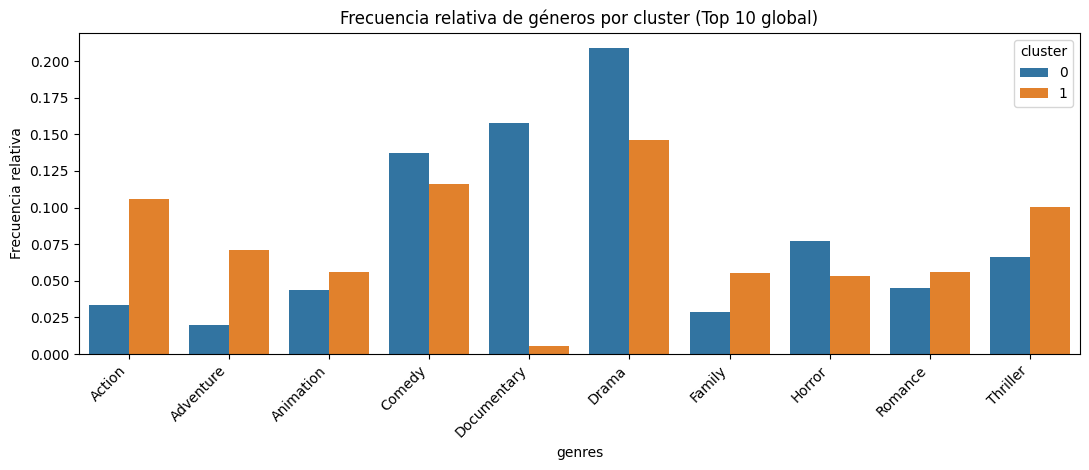

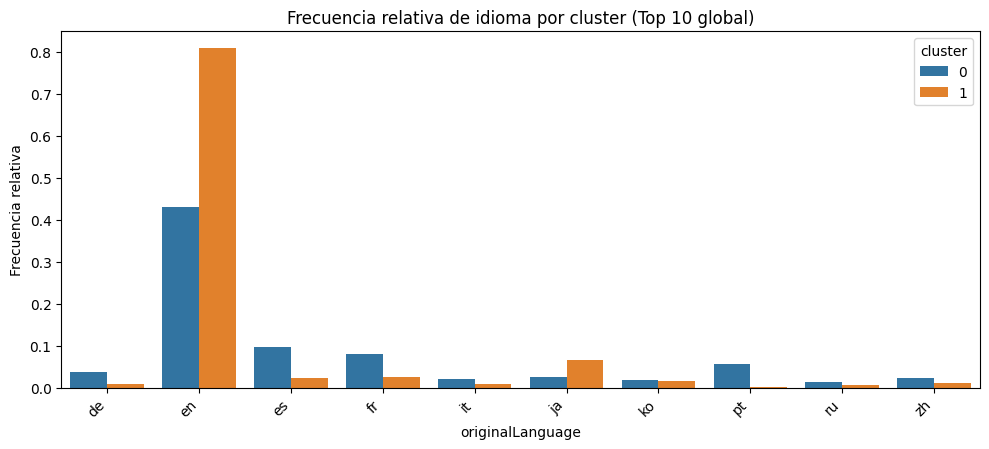

Top 5 géneros por cluster:


,cluster,genres,freq
6,0,Drama,0.208800
5,0,Documentary,0.157801
3,0,Comedy,0.137141
10,0,Horror,0.076944
16,0,Thriller,0.066511
25,1,Drama,0.146174
22,1,Comedy,0.116225
19,1,Action,0.106090
35,1,Thriller,0.100316
20,1,Adventure,0.071197


Top 5 idiomas por cluster:


,cluster,originalLanguage,freq
18,0,en,0.430358
19,0,es,0.095707
24,0,fr,0.078974
65,0,pt,0.056449
15,0,de,0.035947
100,1,en,0.808350
110,1,ja,0.065956
105,1,fr,0.026094
101,1,es,0.021874
111,1,ko,0.016767


In [14]:

df_freq = df_cluster.copy()

# Géneros (multi-etiqueta separada por '|')
genres_long = (
    df_freq[['cluster', 'genres']]
    .assign(genres=lambda x: x['genres'].fillna('').astype(str).str.split('|'))
    .explode('genres')
)
genres_long['genres'] = genres_long['genres'].astype(str).str.strip()
genres_long = genres_long[genres_long['genres'] != '']

genre_counts = genres_long.groupby(['cluster', 'genres']).size().rename('count').reset_index()
genre_counts['freq'] = genre_counts['count'] / genre_counts.groupby('cluster')['count'].transform('sum')
genre_freq = genre_counts[['cluster', 'genres', 'freq']]

top_genres = genre_freq.groupby('genres')['freq'].mean().sort_values(ascending=False).head(10).index
genre_plot = genre_freq[genre_freq['genres'].isin(top_genres)]

plt.figure(figsize=(11, 4.8))
sns.barplot(data=genre_plot, x='genres', y='freq', hue='cluster')
plt.title('Frecuencia relativa de géneros por cluster (Top 10 global)')
plt.xticks(rotation=45, ha='right')
plt.ylabel('Frecuencia relativa')
plt.tight_layout()
plt.show()

# Idioma original
lang_counts = (
    df_freq.assign(originalLanguage=df_freq['originalLanguage'].fillna('Unknown'))
    .groupby(['cluster', 'originalLanguage']).size()
    .rename('count').reset_index()
 )
lang_counts['freq'] = lang_counts['count'] / lang_counts.groupby('cluster')['count'].transform('sum')
lang_freq = lang_counts[['cluster', 'originalLanguage', 'freq']]

top_lang = lang_freq.groupby('originalLanguage')['freq'].mean().sort_values(ascending=False).head(10).index
lang_plot = lang_freq[lang_freq['originalLanguage'].isin(top_lang)]

plt.figure(figsize=(10, 4.6))
sns.barplot(data=lang_plot, x='originalLanguage', y='freq', hue='cluster')
plt.title('Frecuencia relativa de idioma por cluster (Top 10 global)')
plt.xticks(rotation=45, ha='right')
plt.ylabel('Frecuencia relativa')
plt.tight_layout()
plt.show()

top_genres_by_cluster = (
    genre_freq.sort_values(['cluster', 'freq'], ascending=[True, False])
    .groupby('cluster').head(5)
 )
top_lang_by_cluster = (
    lang_freq.sort_values(['cluster', 'freq'], ascending=[True, False])
    .groupby('cluster').head(5)
 )

print('Top 5 géneros por cluster:')
display(top_genres_by_cluster)
print('Top 5 idiomas por cluster:')
display(top_lang_by_cluster)

## Insights para CineVision Studios
**Cluster 0 (54.71%) — Catálogo de menor escala / nicho local-regional**
- Menor `budget`, `revenue`, `popularity`, `voteAvg` y `voteCount` frente al Cluster 1.
- Mayor peso relativo en `Drama`, `Documentary`, `Comedy`, `Horror` y `Thriller`.
- Menor concentración en inglés (`en` ~43.04%) y mayor diversidad lingüística (`es`, `fr`, `pt`, `de`, etc.).

**Cluster 1 (45.29%) — Mainstream internacional / escala alta**
- Mayor `budget`, `revenue`, `popularity`, `voteAvg` y `voteCount`.
- Mezcla fuerte de géneros comerciales: `Drama`, `Comedy`, `Action`, `Thriller` y `Adventure`.
- Dominio de idioma `en` (~80.84%), con aporte menor de `ja`, `fr`, `es` y `ko`.

**Qué le aporta esto a CineVision para encontrar nichos**
1. Separar la cartera en dos estrategias: apuestas globales de alto impacto (Cluster 1) vs. portafolio experimental/local (Cluster 0).
2. Detectar oportunidades en combinaciones género+idioma subatendidas dentro del Cluster 0 (ej. documental/horror no inglés).
3. Diseñar inversión y distribución por cluster: marketing masivo y ventanas amplias para Cluster 1; campañas segmentadas y costos controlados para Cluster 0.
4. Usar la asignación a cluster como filtro temprano de greenlighting para alinear riesgo esperado y retorno potencial.

## PCA (Análisis de Componentes Principales)
Se aplica PCA sobre `X_scaled` para:
1. Cuantificar cuánta varianza explican los componentes.
2. Visualizar la estructura en 2D.
3. Interpretar qué variables pesan más en cada componente.

Varianza explicada acumulada (primeros 10 componentes):
[0.2015 0.2491 0.2832 0.3163 0.3453 0.3727 0.3995 0.4248 0.4485 0.4713]

Componentes requeridos por umbral:


,componentes_para_85pct,componentes_para_90pct,componentes_para_95pct
0,31,35,40


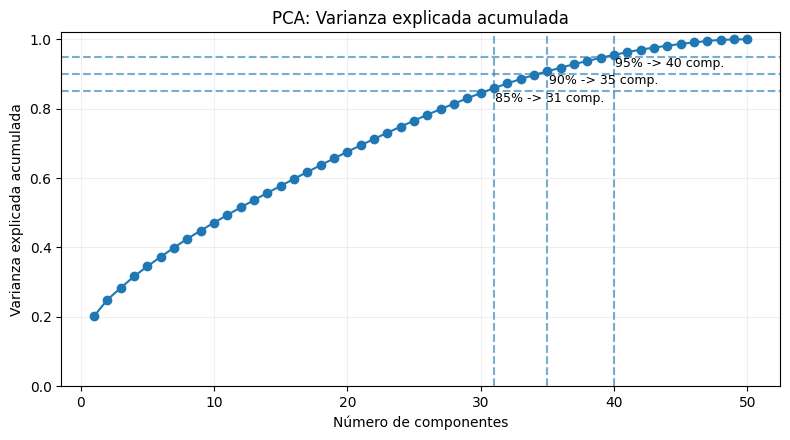

In [15]:
# PCA: varianza explicada y número de componentes
from sklearn.decomposition import PCA

if 'X_scaled' not in globals():
    raise ValueError('No existe X_scaled. Ejecuta las celdas de preprocesamiento y escalado primero.')

pca_full = PCA(random_state=42)
pca_full.fit(X_scaled)

explained = pca_full.explained_variance_ratio_
cum_explained = np.cumsum(explained)

thresholds = [0.85, 0.90, 0.95]
comp_summary = {
    f'componentes_para_{int(t*100)}pct': int(np.argmax(cum_explained >= t) + 1)
    for t in thresholds
}

print('Varianza explicada acumulada (primeros 10 componentes):')
print(np.round(cum_explained[:10], 4))
print('\nComponentes requeridos por umbral:')
display(pd.DataFrame([comp_summary]))

plt.figure(figsize=(8, 4.5))
plt.plot(range(1, len(cum_explained) + 1), cum_explained, marker='o')
for t in thresholds:
    k_t = int(np.argmax(cum_explained >= t) + 1)
    plt.axhline(y=t, linestyle='--', alpha=0.6)
    plt.axvline(x=k_t, linestyle='--', alpha=0.6)
    plt.text(k_t + 0.1, t - 0.03, f'{int(t*100)}% -> {k_t} comp.', fontsize=9)

plt.title('PCA: Varianza explicada acumulada')
plt.xlabel('Número de componentes')
plt.ylabel('Varianza explicada acumulada')
plt.ylim(0, 1.02)
plt.grid(alpha=0.2)
plt.tight_layout()
plt.show()

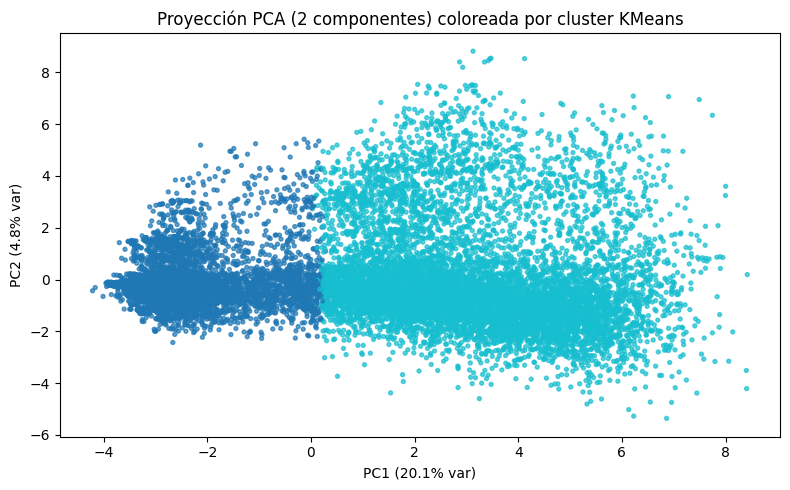

Top variables que más aportan a PC1:


,PC1,PC2
actorsPopularityStd,0.2806,-0.0158
actorsPopularityMax,0.2718,-0.0282
voteCount,0.2673,-0.0902
castMenAmount,0.2544,-0.0591
actorsPopularityMean,0.2520,0.1028
prodCountry_United_States_of_America,0.2482,-0.0079
releaseYear,-0.2459,-0.0033
budget,0.2427,-0.1126


Top variables que más aportan a PC2:


,PC1,PC2
genre_Animation,0.0369,0.4733
genre_Family,0.0638,0.3968
genre_Adventure,0.1048,0.2914
genre_Fantasy,0.0624,0.2847
genre_Thriller,0.0817,-0.2459
prodCountry_Japan,0.0373,0.2389
genre_Drama,0.0359,-0.2100
prodCompany_Warner_Bros._Animation,0.0246,0.2014


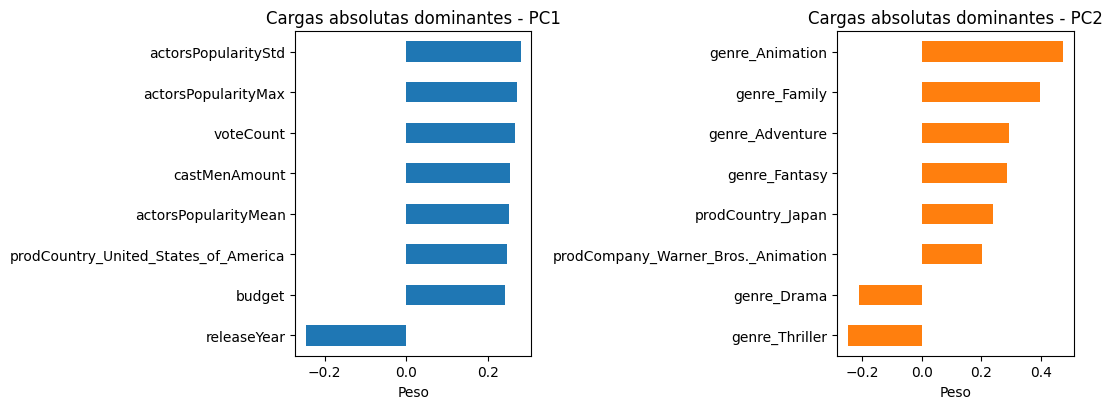

In [16]:
# PCA en 2D para visualización e interpretación de cargas
k_for_vis = 2
pca_2d = PCA(n_components=k_for_vis, random_state=42)
X_pca_2d = pca_2d.fit_transform(X_scaled)

labels_for_plot = labels_kmeans if 'labels_kmeans' in globals() else None

plt.figure(figsize=(8, 5))
if labels_for_plot is not None:
    plt.scatter(X_pca_2d[:, 0], X_pca_2d[:, 1], c=labels_for_plot, s=8, cmap='tab10', alpha=0.7)
    plt.title('Proyección PCA (2 componentes) coloreada por cluster KMeans')
else:
    plt.scatter(X_pca_2d[:, 0], X_pca_2d[:, 1], s=8, alpha=0.7)
    plt.title('Proyección PCA (2 componentes)')

plt.xlabel(f'PC1 ({pca_2d.explained_variance_ratio_[0]*100:.1f}% var)')
plt.ylabel(f'PC2 ({pca_2d.explained_variance_ratio_[1]*100:.1f}% var)')
plt.tight_layout()
plt.show()

loadings = pd.DataFrame(
    pca_2d.components_.T,
    index=X_scaled.columns,
    columns=['PC1', 'PC2']
)

top_pc1 = loadings['PC1'].abs().sort_values(ascending=False).head(8).index
top_pc2 = loadings['PC2'].abs().sort_values(ascending=False).head(8).index

print('Top variables que más aportan a PC1:')
display(loadings.loc[top_pc1].sort_values('PC1', key=lambda s: s.abs(), ascending=False).round(4))
print('Top variables que más aportan a PC2:')
display(loadings.loc[top_pc2].sort_values('PC2', key=lambda s: s.abs(), ascending=False).round(4))

fig, axes = plt.subplots(1, 2, figsize=(11, 4.2))
loadings.loc[top_pc1, 'PC1'].sort_values().plot(kind='barh', ax=axes[0], color='tab:blue')
axes[0].set_title('Cargas absolutas dominantes - PC1')
axes[0].set_xlabel('Peso')

loadings.loc[top_pc2, 'PC2'].sort_values().plot(kind='barh', ax=axes[1], color='tab:orange')
axes[1].set_title('Cargas absolutas dominantes - PC2')
axes[1].set_xlabel('Peso')

plt.tight_layout()
plt.show()

## Reglas de Asociación
Se construyen transacciones por película (géneros + idioma original) y se aplican reglas de asociación para identificar combinaciones frecuentes útiles para decisión de contenido.

In [17]:
# Preparación de transacciones (géneros + idioma)
if 'df' not in globals():
    raise ValueError('No existe df. Ejecuta la celda de carga de datos primero.')

# Función para normalizar tokens de texto

def clean_token(x):
    token = str(x).strip()
    return token if token != '' and token.lower() != 'nan' else None

transactions = []
for _, row in df[['genres', 'originalLanguage']].iterrows():
    items = []

    # Géneros
    genres_raw = [] if pd.isna(row['genres']) else str(row['genres']).split('|')
    genres = [clean_token(g) for g in genres_raw]
    genres = [g for g in genres if g is not None]
    items.extend([f'genre={g}' for g in genres])

    # Idioma
    lang = clean_token(row['originalLanguage'])
    if lang is not None:
        items.append(f'lang={lang}')

    # Evitar transacciones vacías
    if len(items) > 0:
        transactions.append(sorted(set(items)))

print(f'Transacciones construidas: {len(transactions)}')
print('Ejemplo de transacción:', transactions[0][:8] if len(transactions) > 0 else [])

Transacciones construidas: 19883
Ejemplo de transacción: ['genre=Crime', 'genre=Drama', 'lang=fa']


In [18]:
# Reglas de asociación con Apriori
import importlib
import subprocess
import sys

if importlib.util.find_spec('mlxtend') is None:
    print('Instalando mlxtend...')
    subprocess.check_call([sys.executable, '-m', 'pip', 'install', 'mlxtend', '-q'])

from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules

te = TransactionEncoder()
te_array = te.fit(transactions).transform(transactions)
basket = pd.DataFrame(te_array, columns=te.columns_)

# Ajusta estos umbrales según densidad de reglas en tu dataset
min_support = 0.03
min_confidence = 0.35
min_lift = 1.10

frequent_itemsets = apriori(basket, min_support=min_support, use_colnames=True)
rules = association_rules(frequent_itemsets, metric='confidence', min_threshold=min_confidence)

if rules.empty:
    print('No se generaron reglas con los umbrales actuales. Prueba bajar soporte/confianza.')
else:
    rules = rules[rules['lift'] >= min_lift].copy()
    rules['antecedents'] = rules['antecedents'].apply(lambda s: ', '.join(sorted(list(s))))
    rules['consequents'] = rules['consequents'].apply(lambda s: ', '.join(sorted(list(s))))
    rules = rules.sort_values(['lift', 'confidence', 'support'], ascending=[False, False, False])

    cols_view = ['antecedents', 'consequents', 'support', 'confidence', 'lift']
    print(f'Itemsets frecuentes: {len(frequent_itemsets)}')
    print(f'Reglas encontradas (filtradas): {len(rules)}')
    display(rules[cols_view].head(20).round(4))

Itemsets frecuentes: 64
Reglas encontradas (filtradas): 47


,antecedents,consequents,support,confidence,lift
37,genre=Family,"genre=Animation, lang=en",0.0364,0.4153,7.4454
33,"genre=Animation, lang=en",genre=Family,0.0364,0.6519,7.4454
34,"genre=Family, lang=en",genre=Animation,0.0364,0.5379,5.4020
36,genre=Animation,"genre=Family, lang=en",0.0364,0.3652,5.4020
6,genre=Animation,genre=Family,0.0440,0.4419,5.0469
7,genre=Family,genre=Animation,0.0440,0.5026,5.0469
3,genre=Family,genre=Adventure,0.0349,0.3980,3.9473
4,genre=Fantasy,genre=Adventure,0.0324,0.3924,3.8917
30,genre=Adventure,"genre=Action, lang=en",0.0363,0.3596,3.3333
44,"genre=Crime, lang=en",genre=Thriller,0.0326,0.5595,3.2883


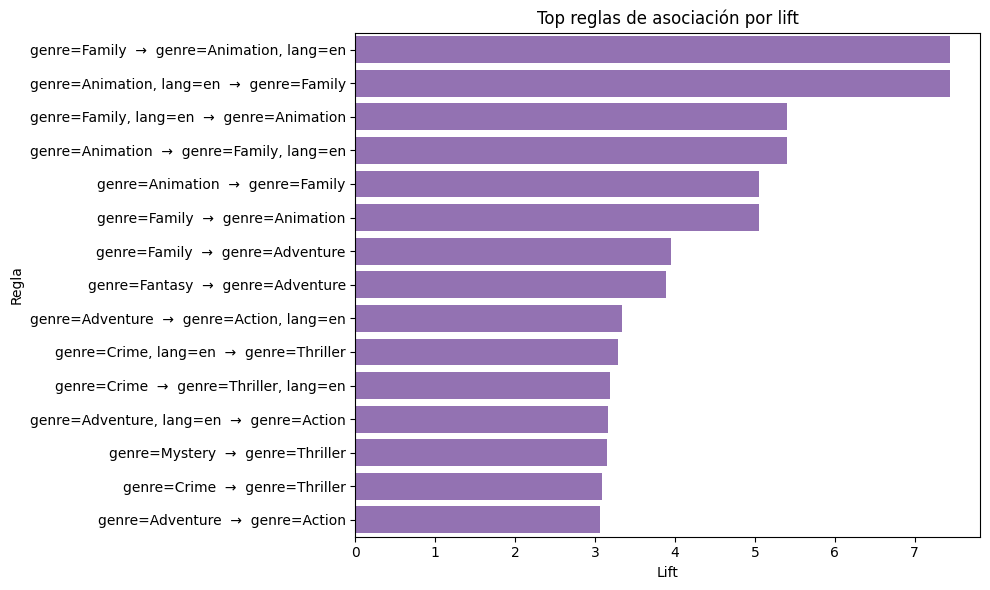

In [19]:
# Visualización rápida de reglas top (lift)
if 'rules' in globals() and not rules.empty:
    top_rules_plot = rules.head(15).copy()
    top_rules_plot['rule'] = top_rules_plot['antecedents'] + '  →  ' + top_rules_plot['consequents']

    plt.figure(figsize=(10, 6))
    sns.barplot(data=top_rules_plot, y='rule', x='lift', color='tab:purple')
    plt.title('Top reglas de asociación por lift')
    plt.xlabel('Lift')
    plt.ylabel('Regla')
    plt.tight_layout()
    plt.show()
else:
    print('No hay reglas para visualizar.')

# 4. Otros Algoritmos de Aprendizaje No Supervisado: t-SNE

## 4.1 Justificación de la elección

Se eligió **t-SNE (t-Distributed Stochastic Neighbor Embedding)** por las siguientes razones aplicadas a este dataset:

1. **Alta dimensionalidad**: La matriz de features construida para clustering tiene 50 dimensiones (variables numéricas + one-hot de géneros, países y productoras). t-SNE es ideal para proyectar espacios de alta dimensión a 2D manteniendo la estructura local de los datos.
2. **Validación visual de clusters**: Permite visualizar si los grupos encontrados por K-Means y clustering jerárquico tienen cohesión real en el espacio de características, confirmando o cuestionando los resultados del clustering.
3. **Descubrimiento de subgrupos**: A diferencia de PCA (que captura varianza global), t-SNE revela agrupaciones no lineales, útiles para detectar nichos cinematográficos que métricas lineales podrían ocultar (ej. películas de bajo presupuesto con alta popularidad).
4. **Complementariedad con PCA**: PCA ya capturó la varianza explicada; t-SNE complementa mostrando la estructura de vecindad local entre películas similares.

**Limitación a tener en cuenta**: t-SNE no preserva distancias globales, por lo que la distancia entre grupos en el gráfico no es directamente interpretable, solo la cohesión dentro de cada grupo.

In [22]:
# ── Parte 4: t-SNE ────────────────────────────────────────────────────────────
from sklearn.manifold import TSNE
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Verificar que las variables del clustering anterior estén disponibles
# El notebook usa: X_scaled (array escalado) y labels_kmeans (array de etiquetas)
assert 'X_scaled' in dir() or 'X_scaled' in globals(), \
    "X_scaled no encontrado. Ejecuta primero las celdas de Clustering."
assert 'labels_kmeans' in dir() or 'labels_kmeans' in globals(), \
    "labels_kmeans no encontrado. Ejecuta primero las celdas de Clustering."

print(f"Dimensiones de X_scaled : {X_scaled.shape}")
print(f"Clusters disponibles    : {np.unique(labels_kmeans)}")
print(f"Distribución:\n{pd.Series(labels_kmeans).value_counts().sort_index().to_string()}")

Dimensiones de X_scaled : (19883, 50)
Clusters disponibles    : [0 1]
Distribución:
0    10877
1     9006


In [24]:
# t-SNE escala cuadráticamente: se usa muestra estratificada por cluster
SAMPLE_SIZE  = 5000
RANDOM_STATE = 42
rng = np.random.default_rng(RANDOM_STATE)

# Índices de muestra estratificada (misma proporción por cluster)
sample_idx_list = []
for cl in np.unique(labels_kmeans):
    idx_cl = np.where(labels_kmeans == cl)[0]
    n_cl   = max(1, int(SAMPLE_SIZE * len(idx_cl) / len(labels_kmeans)))
    chosen = rng.choice(idx_cl, size=min(n_cl, len(idx_cl)), replace=False)
    sample_idx_list.append(chosen)

sample_idx    = np.concatenate(sample_idx_list)

# ← CORRECCIÓN: usar .iloc si X_scaled es DataFrame, o .values primero
X_arr         = X_scaled.values if hasattr(X_scaled, 'values') else X_scaled
X_sample      = X_arr[sample_idx]
labels_sample = labels_kmeans[sample_idx]

# Género principal para colorear (usa las columnas genre_* del df)
genre_cols = [c for c in df.columns if c.startswith('genre_')]
if genre_cols:
    main_genre_sample = (
        df.iloc[sample_idx][genre_cols]
        .idxmax(axis=1)
        .str.replace('genre_', '', regex=False)
        .values
    )
else:
    main_genre_sample = np.array(['N/A'] * len(sample_idx))

print(f"Muestra: {len(sample_idx)} de {X_arr.shape[0]} películas")
print(f"Distribución en muestra:\n{pd.Series(labels_sample).value_counts().sort_index().to_string()}")

Muestra: 4999 de 19883 películas
Distribución en muestra:
0    2735
1    2264


In [26]:
# ── Ajustar t-SNE ─────────────────────────────────────────────────────────────
from sklearn.manifold import TSNE
import sklearn

tsne = TSNE(
    n_components=2,
    perplexity=40,
    max_iter=1000,        # ← 'n_iter' se renombró a 'max_iter' en sklearn ≥1.2
    learning_rate='auto',
    init='pca',
    random_state=RANDOM_STATE
)

print(f"sklearn version: {sklearn.__version__}")
print("Ejecutando t-SNE... (puede tardar 1-3 minutos)")
X_tsne = tsne.fit_transform(X_sample)

df_tsne = pd.DataFrame({
    'tsne_1'     : X_tsne[:, 0],
    'tsne_2'     : X_tsne[:, 1],
    'cluster'    : labels_sample,
    'main_genre' : main_genre_sample
})

print(f"t-SNE listo. KL divergence final: {tsne.kl_divergence_:.4f}")

sklearn version: 1.8.0
Ejecutando t-SNE... (puede tardar 1-3 minutos)
t-SNE listo. KL divergence final: 0.6628


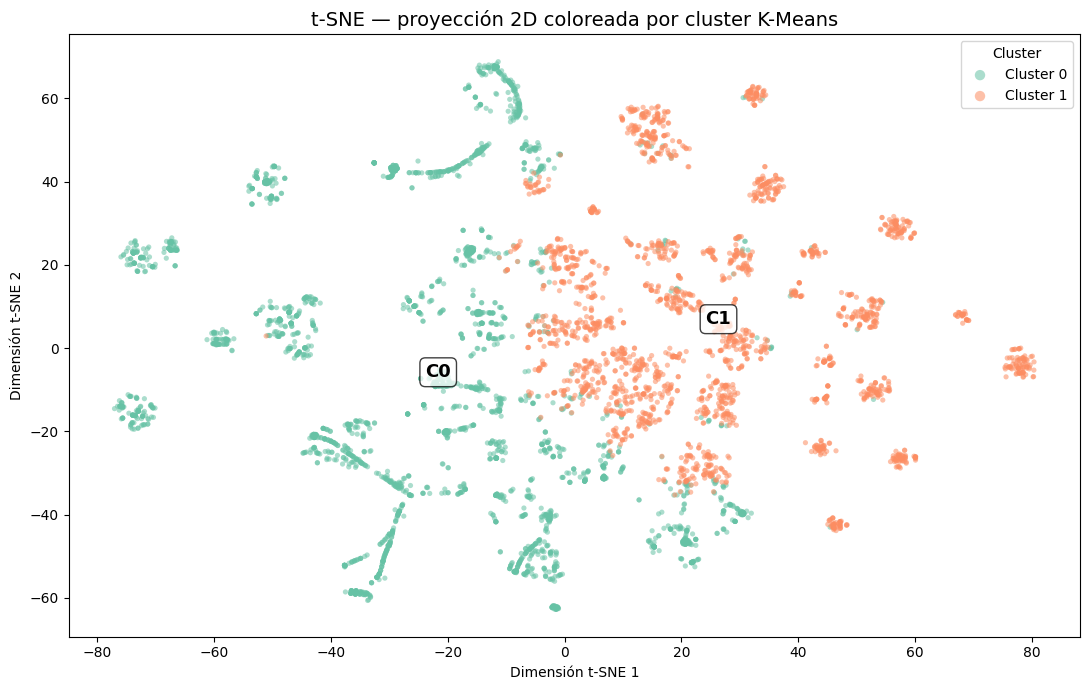

In [31]:
# ── Gráfica 1: coloreado por cluster K-Means ──────────────────────────────────
n_clusters = len(np.unique(labels_sample))
palette    = sns.color_palette('Set2', n_colors=n_clusters)

fig, ax = plt.subplots(figsize=(11, 7))
for i, cl in enumerate(sorted(np.unique(labels_sample))):
    mask = df_tsne['cluster'] == cl
    ax.scatter(
        df_tsne.loc[mask, 'tsne_1'],
        df_tsne.loc[mask, 'tsne_2'],
        c=[palette[i]], label=f'Cluster {cl}',
        alpha=0.55, s=14, edgecolors='none'
    )

# Anotar centroide aproximado de cada cluster
for cl in sorted(np.unique(labels_sample)):
    cx = df_tsne.loc[df_tsne['cluster'] == cl, 'tsne_1'].mean()
    cy = df_tsne.loc[df_tsne['cluster'] == cl, 'tsne_2'].mean()
    ax.annotate(f'C{cl}', xy=(cx, cy), fontsize=13, fontweight='bold',
                ha='center', va='center',
                bbox=dict(boxstyle='round,pad=0.3', fc='white', alpha=0.75))

ax.set_title('t-SNE — proyección 2D coloreada por cluster K-Means', fontsize=14)
ax.set_xlabel('Dimensión t-SNE 1')
ax.set_ylabel('Dimensión t-SNE 2')
ax.legend(title='Cluster', markerscale=2)
plt.tight_layout()
plt.show()

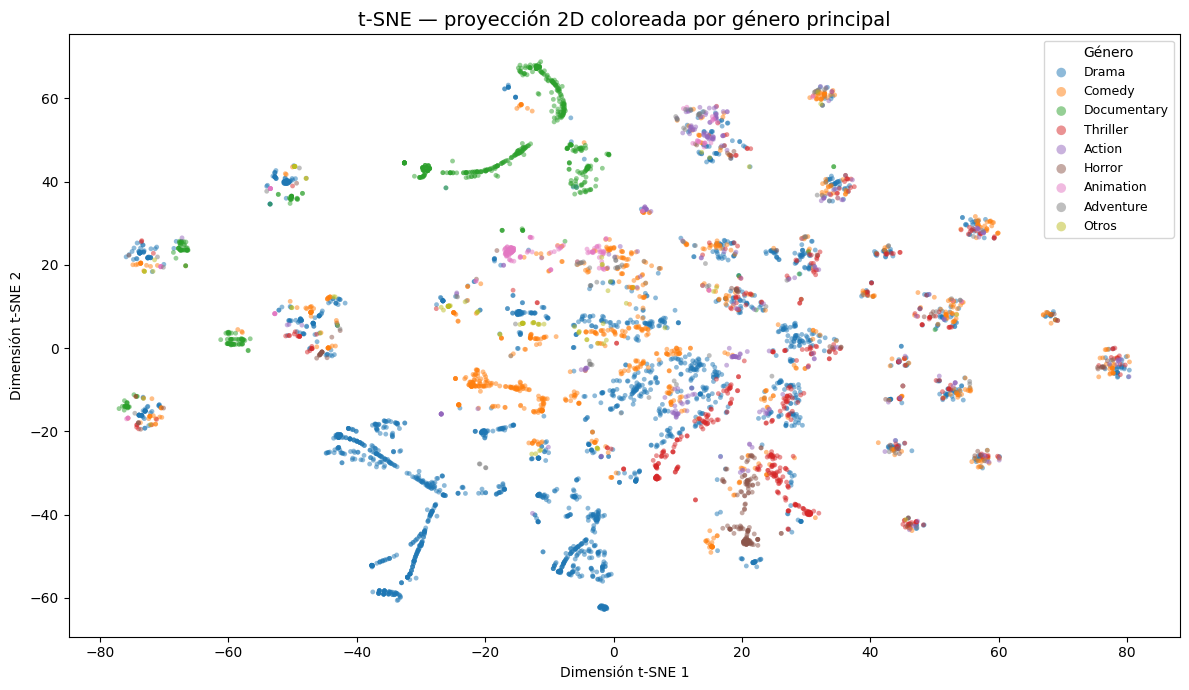

In [32]:
# ── Gráfica 2: coloreado por género principal ─────────────────────────────────
top_genres = pd.Series(main_genre_sample).value_counts().head(8).index.tolist()
df_tsne['genre_label'] = [
    g if g in top_genres else 'Otros' for g in df_tsne['main_genre']
]
genre_order   = top_genres + ['Otros']
genre_palette = sns.color_palette('tab10', n_colors=len(genre_order))

fig, ax = plt.subplots(figsize=(12, 7))
for i, g in enumerate(genre_order):
    mask = df_tsne['genre_label'] == g
    ax.scatter(
        df_tsne.loc[mask, 'tsne_1'],
        df_tsne.loc[mask, 'tsne_2'],
        c=[genre_palette[i]], label=g,
        alpha=0.50, s=12, edgecolors='none'
    )

ax.set_title('t-SNE — proyección 2D coloreada por género principal', fontsize=14)
ax.set_xlabel('Dimensión t-SNE 1')
ax.set_ylabel('Dimensión t-SNE 2')
ax.legend(title='Género', markerscale=2, fontsize=9, loc='best')
plt.tight_layout()
plt.show()

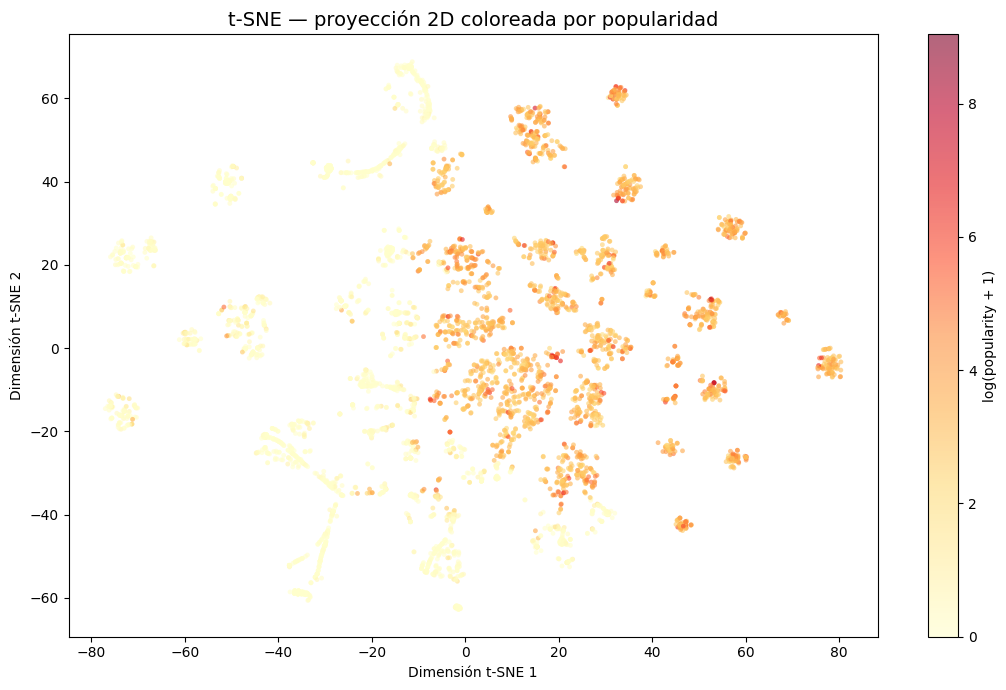

In [33]:
# ── Gráfica 3: gradiente de popularidad ──────────────────────────────────────
pop_sample = np.log1p(df.iloc[sample_idx]['popularity'].values)

fig, ax = plt.subplots(figsize=(11, 7))
sc = ax.scatter(
    df_tsne['tsne_1'], df_tsne['tsne_2'],
    c=pop_sample, cmap='YlOrRd',
    alpha=0.6, s=12, edgecolors='none'
)
cbar = plt.colorbar(sc, ax=ax)
cbar.set_label('log(popularity + 1)', fontsize=10)

ax.set_title('t-SNE — proyección 2D coloreada por popularidad', fontsize=14)
ax.set_xlabel('Dimensión t-SNE 1')
ax.set_ylabel('Dimensión t-SNE 2')
plt.tight_layout()
plt.show()

In [30]:
# ── Tabla resumen: métricas originales por cluster en la muestra ──────────────
num_cols_viz = ['popularity', 'budget', 'revenue', 'runtime', 'voteAvg', 'voteCount']
df_sample_stats = df.iloc[sample_idx][num_cols_viz].copy()
df_sample_stats['cluster'] = labels_sample

# Dispersión t-SNE por cluster (menor = más cohesión visual)
dispersion = (
    df_tsne.groupby('cluster')[['tsne_1', 'tsne_2']]
    .std().mean(axis=1)
    .rename('dispersion_tsne')
)

cluster_summary = (
    df_sample_stats.groupby('cluster')[num_cols_viz]
    .median()
    .round(2)
    .join(dispersion.round(2))
)

print("Mediana por cluster (muestra) + dispersión en espacio t-SNE:")
display(cluster_summary)

Mediana por cluster (muestra) + dispersión en espacio t-SNE:


,popularity,budget,revenue,runtime,voteAvg,voteCount,dispersion_tsne
cluster,,,,,,,
0,0.07,0.0,0.0,13.0,0.0,0.0,30.26
1,22.14,3500000.0,3183807.5,101.0,6.5,528.5,22.49
